In [1]:
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli
import numpy as np

from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\Documents\Python Scripts\Quantum_Optimal_Control\rl_qoc\helpers\__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


In [2]:
def shadow_bound_state(error, observables, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    return max(int(np.ceil(N * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this


In [3]:
def shadow_bound_state2(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i] for i in range(len(observables))) / error ** 2
    print(sum(np.abs(coeffs[i]) for i in range(len(observables))))
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

def shadow_bound_state3(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)

    N = np.sum([np.abs(coeffs[i]) for i in range(len(observables))]) * 3 ** (np.log2(observables[0].shape[0])) * np.log(M) / error ** 2
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this


In [5]:
# TEST 1: 2 qubits, 1 parameter only

# simplified 2 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    #test circuit 1
    qc.ry(params[0], 0)
    qc.cx(0,1)

# 2 qubit parametrized bell state of one parameter
theta = np.pi #generate a random target state; this is the goal we want to obtain
tgt_state = (np.cos(theta/2) * Statevector.from_label('00') + np.sin(theta/2) * Statevector.from_label('11'))  
tgt_state_dm = DensityMatrix(tgt_state)
params =  np.array([[theta]])

observable_decomp = SparsePauliOp.from_operator(Operator(tgt_state_dm))
pauli_coeff = observable_decomp.coeffs   #to also be used in shadow bound
pauli_str = observable_decomp.paulis
observables = [Pauli(str).to_matrix() for str in pauli_str]
error = 0.1  # Set the error tolerance for the shadow bound state
shadow_size, partition, no_observables = shadow_bound_state2(error, observables, pauli_coeff)
print("Shadow Size, Partition, Number of Observables: ", shadow_size, partition, no_observables)

1.0
Shadow Size, Partition, Number of Observables:  102275 13 4


In [6]:
#TEST 2: 2 qubits, random target state
def calculate_shadow_bounds(tgt_state_dm, error):
    observable_decomp = SparsePauliOp.from_operator(Operator(tgt_state_dm))
    pauli_coeff = observable_decomp.coeffs   #to also be used in shadow bound
    pauli_str = observable_decomp.paulis
    observables = [Pauli(str).to_matrix() for str in pauli_str]
    shadow_size, partition, no_observables = shadow_bound_state2(error, observables, pauli_coeff)
    print("Shadow Size, Partition, Number of Observables: ", shadow_size, partition, no_observables)

    shadow_size, partition, no_observables = shadow_bound_state3(error, observables, pauli_coeff)
    print("Shadow Size, Partition, Number of Observables, 3^k: ", shadow_size, partition, no_observables)

#TEST 3: 2 qubits , random target state, no decomposition
def calculate_shadow_bounds_no_decomp(tgt_state_dm, error):
    observables = [tgt_state_dm.data]
    shadow_size, partition, no_observables = shadow_bound_state(error, observables, failure_rate=0.01)
    print("Shadow Size, Partition, Number of Observables, no decomp: ", shadow_size, partition, no_observables)

for n in range(1):
    no_qubits = 4
    error = 0.1
    tgt_state = random_statevector(2**no_qubits)  
    tgt_state_dm = DensityMatrix(tgt_state)
    calculate_shadow_bounds(tgt_state_dm, error)
    calculate_shadow_bounds_no_decomp(tgt_state_dm, error)

# decompose is almost always better for the bounds
print("DM dimensions: " , tgt_state_dm.data.shape)

3.22648423648091
Shadow Size, Partition, Number of Observables:  1036910 21 256
Shadow Size, Partition, Number of Observables, 3^k:  3142891 21 256
Shadow Size, Partition, Number of Observables, no decomp:  127712 10 1
DM dimensions:  (16, 16)


In [199]:
# Choi State; 1 Qubit Test, ry gate
num_qubits = 1
error = 0.1

params = np.array([np.random.rand()*2* np.pi])
qc = QuantumCircuit(num_qubits)
qc.ry(2*params[0], 0)
specific_gate = qc.to_gate(label="U_entangle")
gate_target = GateTarget(specific_gate)
target_choi = Choi(gate_target.target_operator)
target_choi_dm = DensityMatrix(target_choi.data/ 2**num_qubits)
calculate_shadow_bounds(target_choi_dm, error)
calculate_shadow_bounds_no_decomp(target_choi_dm, error)
print("DM dimensions: " , target_choi_dm.data.shape)

Shadow Size, Partition, Number of Observables:  27120 14 6
Shadow Size, Partition, Number of Observables, no decomp:  102466 10 1
DM dimensions:  (4, 4)


In [200]:
# Choi State; 1 Qubit Test, randomised U gate
num_qubits = 1
error = 0.1

params = ParameterVector("theta", 3)
qc = QuantumCircuit(1)
qc.u(params[0], params[1], params[2], 0)


# Create parameterized gate
param_gate = qc.to_gate(label="U_entangle")
param_random = np.array([np.random.rand()*2* np.pi for n in range(3)])
bound_qc = qc.assign_parameters({
    params[0]: param_random[0],
    params[1]: param_random[1],
    params[2]: param_random[2],
})

specific_gate = bound_qc.to_gate(label="U_entangle")

gate_target = GateTarget(specific_gate)

target_choi = Choi(gate_target.target_operator)
target_choi_dm = DensityMatrix(target_choi.data / 2**num_qubits)
calculate_shadow_bounds(target_choi_dm, error)
calculate_shadow_bounds_no_decomp(target_choi_dm, error)
print("DM dimensions: " , target_choi_dm.data.shape)

Shadow Size, Partition, Number of Observables:  29074 15 10
Shadow Size, Partition, Number of Observables, no decomp:  71985 10 1
DM dimensions:  (4, 4)


In [201]:
# Choi State; 2 Qubit Test, randomised U gate
num_qubits = 2
error = 0.1

params = ParameterVector("theta", 6)
qc = QuantumCircuit(num_qubits)
qc.u(params[0], params[1], params[2], 0)
qc.u(params[3], params[4], params[5], 1)
qc.cx(0, 1)

# Create parameterized gate
param_gate = qc.to_gate(label="U_entangle")
param_random = np.array([np.random.rand()*2* np.pi for n in range(6)])
bound_qc = qc.assign_parameters({
    params[0]: param_random[0],
    params[1]: param_random[1],
    params[2]: param_random[2],
    params[3]: param_random[3],
    params[4]: param_random[4],
    params[5]: param_random[5],
})

specific_gate = bound_qc.to_gate(label="U_entangle")

gate_target = GateTarget(specific_gate)

target_choi = Choi(gate_target.target_operator)
target_choi_dm = DensityMatrix(target_choi.data / 2**num_qubits)
calculate_shadow_bounds(target_choi_dm, error)
calculate_shadow_bounds_no_decomp(target_choi_dm, error)
print("DM dimensions: " , target_choi_dm.data.shape)

Shadow Size, Partition, Number of Observables:  59189 19 100
Shadow Size, Partition, Number of Observables, no decomp:  125244 10 1
DM dimensions:  (16, 16)


In [202]:
#study fidelity between decomposed and original choi state - teh breakdown is correct

observable_decomp = SparsePauliOp.from_operator(Operator(target_choi_dm))
pauli_coeff = observable_decomp.coeffs   #to also be used in shadow bound
pauli_str = observable_decomp.paulis
observables = [Pauli(str).to_matrix() for str in pauli_str]
observable_total = np.zeros(observables[0].shape, dtype=complex)
for i in range(len(pauli_str)):
    observable_total += pauli_coeff[i] * observables[i]

observable_total_dm = DensityMatrix(observable_total / np.trace(observable_total))
print("Fidelity between original and decomposed DM: ", state_fidelity(target_choi_dm, observable_total_dm))

Fidelity between original and decomposed DM:  1.0000000000000009


In [203]:
# Choi State; 4 Qubit Test, randomised U gate
num_qubits = 4
error = 0.1

params = ParameterVector("theta", 3*num_qubits)
qc = QuantumCircuit(num_qubits)
qc.u(params[0], params[1], params[2], 0)
qc.u(params[3], params[4], params[5], 1)
qc.u(params[6], params[7], params[8], 2)
qc.u(params[9], params[10], params[11], 3)
qc.cx(0, 1)
qc.cx(0, 2)
qc.cx(1, 2)
qc.cx(0, 3)
qc.cx(1, 3)
qc.cx(2, 3)

# Create parameterized gate
param_gate = qc.to_gate(label="U_entangle")
param_random = np.array([np.random.rand()*2* np.pi for n in range(num_qubits*3)])
bound_qc = qc.assign_parameters({
    params[0]: param_random[0],
    params[1]: param_random[1],
    params[2]: param_random[2],
    params[3]: param_random[3],
    params[4]: param_random[4],
    params[5]: param_random[5],
    params[6]: param_random[6],
    params[7]: param_random[7],
    params[8]: param_random[8],
    params[9]: param_random[9],
    params[10]: param_random[10],
    params[11]: param_random[11],
})

specific_gate = bound_qc.to_gate(label="U_entangle")

gate_target = GateTarget(specific_gate)

target_choi = Choi(gate_target.target_operator)
target_choi_dm = DensityMatrix(target_choi.data / 2**num_qubits)
calculate_shadow_bounds(target_choi_dm, error)
calculate_shadow_bounds_no_decomp(target_choi_dm, error)
print("DM dimensions: " , target_choi_dm.data.shape)

Shadow Size, Partition, Number of Observables:  97235 28 9075
Shadow Size, Partition, Number of Observables, no decomp:  196134 10 1
DM dimensions:  (256, 256)


In [ ]:
#test for 
import numpy as np
import matplotlib.pyplot as plt
def x_at_y_linear(x, y, y_target=0.01):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Find indices where y crosses y_target
    indices = np.where(np.diff(np.sign(y - y_target)))[0]

    if len(indices) == 0:
        raise ValueError("y_target is out of the range of y values.")

    # Take the first crossing for simplicity
    idx = indices[0]

    # Linear interpolation to find the corresponding x value
    x1, x2 = x[idx], x[idx + 1]
    y1, y2 = y[idx], y[idx + 1]

    # Calculate the slope
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the x value at y_target
    x_target = x1 + (y_target - y1) / slope

    return x_target

Estimated x: 6020.62956781791


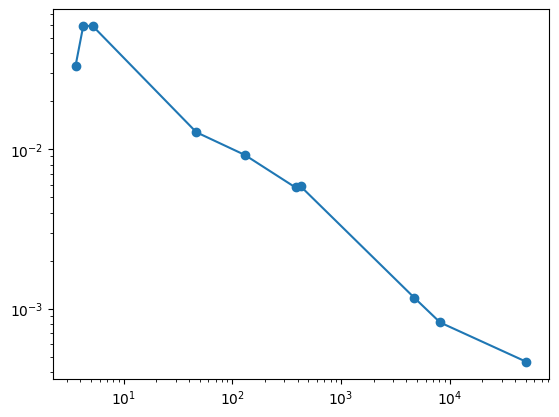

In [55]:
x_log = np.sort(np.random.rand(10)*5)
x = 10** x_log
y = 10**-1 * x **-.5  *( 1 + 0.2 * np.random.randn(len(x)))
y_log = np.log10(y)

plt.plot(x, y, marker='o')
#x_target = x_at_y_linear(x, y, y_target=-3000)
#print(f"Estimated x at y=0.01: {x_target}")
x_target = 10**x_at_y_linear(np.log10(x), np.log10(y), y_target=np.log10(0.001))
plt.xscale('log')
plt.yscale('log')

print(f"Estimated x: {x_target}")

Estimated x: 2.878471214480813


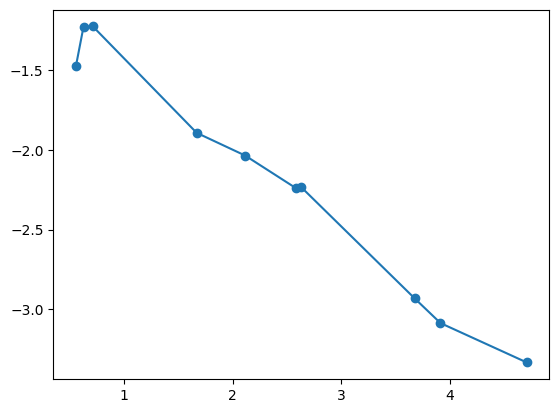

In [56]:
plt.plot(x_log, y_log, marker='o')
x_target = x_at_y_linear(x_log, y_log, y_target=-2.4)
print(f"Estimated x: {x_target}")

In [ ]:
# Build |J> (OUT,IN order) and compare to Qiskit Choi
from qiskit import QuantumCircuit

def qc_target_su4(params):
    """
    Universal 2-qubit ansatz (covers SU(4)):
    [U⊗U] - CX(0,1) - [U⊗U] - CX(1,0) - [U⊗U] - CX(0,1) - [U⊗U]
    params: length 24 (8 single-qubit U's × 3 params each).
    """
    if len(params) != 24:
        raise ValueError("params must have length 24")
    qc = QuantumCircuit(2, name="U_su4")

    # block 0
    qc.u(params[0],  params[1],  params[2],  0)
    qc.u(params[3],  params[4],  params[5],  1)

    qc.cx(0, 1)

    # block 1
    qc.u(params[6],  params[7],  params[8],  0)
    qc.u(params[9],  params[10], params[11], 1)

    qc.cx(1, 0)

    # block 2
    qc.u(params[12], params[13], params[14], 0)
    qc.u(params[15], params[16], params[17], 1)

    qc.cx(0, 1)

    # block 3
    qc.u(params[18], params[19], params[20], 0)
    qc.u(params[21], params[22], params[23], 1)

    return qc



def choi_pure_state_circuit_for_unitary_su4(params):
    """
    |J(U)> builder where U is a *general* 2-qubit unitary on OUT=(q0,q1).
    Qubit order: [OUT0, OUT1, IN0, IN1].
    params: length 24 (overparameterized but universal for SU(4)).
    """
    if len(params) != 24:
        raise ValueError("params must have length 24")

    qc = QuantumCircuit(4, name="|J(U)>")

    # Prepare |Phi+> across (IN0,OUT0) and (IN1,OUT1)
    qc.h(2); qc.cx(2, 0)
    qc.h(3); qc.cx(3, 1)

    # --- General SU(4) on OUT=(q0,q1): 3 CNOTs + single-qubit layers ---
    # Layer 0
    qc.u(params[0],  params[1],  params[2],  0)
    qc.u(params[3],  params[4],  params[5],  1)
    qc.cx(0, 1)

    # Layer 1
    qc.u(params[6],  params[7],  params[8],  0)
    qc.u(params[9],  params[10], params[11], 1)
    qc.cx(1, 0)

    # Layer 2
    qc.u(params[12], params[13], params[14], 0)
    qc.u(params[15], params[16], params[17], 1)
    qc.cx(0, 1)

    # Final local layer
    qc.u(params[18], params[19], params[20], 0)
    qc.u(params[21], params[22], params[23], 1)

    return qc
params24 = np.random.rand(24)*2* np.pi
psi = Statevector.from_instruction(choi_pure_state_circuit_for_unitary_su4(params24))
J_from_circ = 4.0 * np.outer(psi.data, psi.data.conj())    # trace = 4
J_qiskit = Choi(Operator(qc_target_su4(params24))).data
print(np.linalg.norm(J_from_circ - J_qiskit))  # ~1e-12

3.202648290362074e-15


In [81]:
tgt_param = np.random.rand(24)*2* np.pi
qc_target_ = qc_target_su4(tgt_param)

target_choi = Choi(SuperOp(qc_target_))

observable_decomp = SparsePauliOp.from_operator(Operator(target_choi.data / 4))
pauli_coeff = observable_decomp.coeffs   #to also be used in shadow bound
pauli_str = observable_decomp.paulis
observables = [Pauli(str).to_matrix() for str in pauli_str]

def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 100), int(K), M           #sometimes N =

error = 0.1  # Set the error tolerance for the shadow bound state
shadow_size, partition, no_observables = shadow_bound_state(error, observables, pauli_coeff)
print("Shadow Size, Partition, Number of Observables: ", shadow_size, partition, no_observables)

Shadow Size, Partition, Number of Observables:  64036 21 225


In [83]:
A = [-4.89829303662517,
-1.69388374712453,
-2.65096994925323,
-6.67526441173431,
-5.47146510923252,
-23.0928367568759,
-4.01194167473079,
-7.20489239577272,
-5.88445606517335,
-6.33100011794233,
-6.76553700378218,
-2.69179013552159,
-5.80362824156201,
-7.10625836984307,
-4.94701097337857,
-3.80226235229639,
-21.9749227626493,
-9.70166980659125,
-4.54824383719327,
-13.827708157124,
-5.45156507887216,
-5.17700030417386,
-9.53070459851976,
-4.95903362936555,
-3.50207272220254,
-2.29506142271711,
-10.3505797812371,
-36.5992498909631,
-5.26847811406208,
-1.47043464191608,
-5.53130975137481,
-10.0057371941235,
-6.04170859231003,
-16.2179879488766,
-25.1803293340462,
-10.6207588796801,
-5.05603671618113,
-5.61669420100737,
-12.3096705138789,
-3.79478071881333,
-4.96462570460283,
-10.269187347082,
-12.2533193158187,
-18.6828669837057,
-5.61704307785307,
-9.17398804807632,
-9.82690474036861,
-6.05918629115176,
-3.8197731975832]
B = [-3.96844271174773,
1.05078067843545,
-0.108708580758142,
-6.21285090214754,
-4.90899786619971,
-34.218238501838,
-2.75684008042519,
-7.46743251584957,
-6.10955651709123,
-5.50806568933046,
-6.87525370239494,
-0.688083277957539,
-4.97535473717838,
-7.94737408384859,
-3.97904107126763,
-2.2101484670372,
-28.2449042877922,
-11.8683497296835,
-3.27866627221345,
-16.9289536111718,
-5.01676357347513,
-4.47423624737233,
-11.2226693525658,
-4.17403188249703,
-1.24990855029131,
-0.339503649072243,
-12.6543060971655,
-55.2171445953328,
-4.09700091006214,
1.76619875988592,
-5.50485101201689,
-11.8137104387324,
-6.01806010870124,
-22.503031462978,
-38.3578319814133,
-11.4471585423318,
-3.91992013874375,
-4.49661873049741,
-16.6218374059635,
-2.30550081483402,
-4.44291765611961,
-12.4501772884658,
-14.7108123183437,
-27.5417443260998,
-5.10428104395777,
-10.3112964575386,
-12.65125912966,
-5.72729390859533,
-2.39823328669344,
]
C = [14704.0314122095,
35889.5790647688,
11337.326620596,
29845.4727764087,
29754.0553238628,
30948.7476799503,
9872.6028164126,
31000.7682403928,
18789.2621636102,
36303.3554864228,
11658.6576250908,
12269.1874428315,
30923.0649594719,
28527.3369342725,
11039.5787306564,
14056.5765000163,
14598.4205806258,
13495.2745970325,
23846.7543566661,
52938.6331278062,
18417.2648666961,
19818.6497328929,
16032.6864291894,
12990.0357612773,
25357.3795536287,
15269.4264344738,
36879.5994854453,
27271.9645577356,
24485.4499392977,
42217.5392042184,
34505.7600957434,
28571.7939603954,
8195.94094499358,
24194.6607496166,
45011.6208416121,


24370.9763352622,
20045.0460850687,
5830.95874623678,
42935.4573696556,
14603.5314002191,


25487.1821758436,

16437.4834588243,
15728.17813085,
11983.9698005313,
]
D = [673198.843934388,
27450.3681075632,
156038.338666025,
13730233.4460695,
1081265.51521886,
927758649380.072,
184945.287196926,
8756938.01665161,
456410.485483327,
14253927.5343716,
4527102.26568724,
49601.7493119592,
4284515.77266311,
1841376.75242905,
822206.442620912,
247956.922533222,
5069221142121920,
34275980.2170827,
657387.439923183,
53267547653.986,
769779.930809458,
758166.098478208,
68982645.3144335,
554670.892827786,
567854.267762529,
17808.1660429598,
111391862.445898,
957977230142981000,
2753945.35194694,
50941.0677462158,
361217.257301466,
157675402.942542,
1162403.94688755,
8569281996.87495,
1006529914139.92,
6228152199.48315,
1556514.94022439,
5454684.94641375,
99426836.560911,
192336.019036483,
306431.744131985,
122517296.7026,
6249227184.37083,
6667908648.87528,
1348357.67564021,
108812713.005986,
10058896.7671662,
2460813.34726572,
174306.30973517,
]

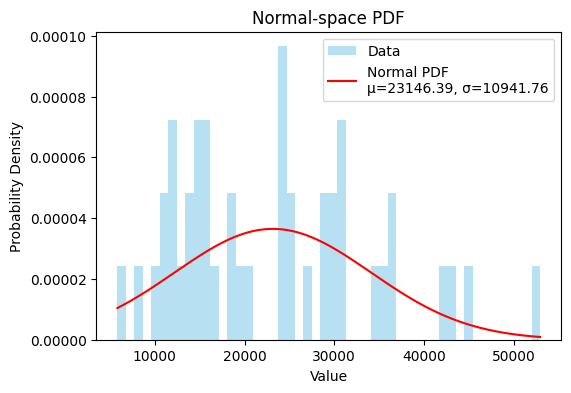

In [ ]:
from scipy.stats import norm

# Example data (replace this with your array)
values = C
print("Mean:", np.mean(values))
print("Median:", np.median(values))
# --- NORMAL PDF ---
plt.figure(figsize=(6,4))
plt.hist(values, bins=50, density=True, alpha=0.6, color='skyblue', label='Data')

# Fit normal distribution
mu, sigma = norm.fit(values)
x = np.linspace(min(values), max(values), 300)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', label=f'Normal PDF\nμ={mu:.2f}, σ={sigma:.2f}')
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Normal-space PDF")
plt.legend()
plt.show()

In [95]:
np.median(C)

np.float64(21945.9002208674)